## **Timeseries Forecasting Models**

Classical models generate forecasts by decomposing a series into deterministic and stochastic components. AR models compute outputs as weighted sums of previous observations, while MA models use past residual errors to adjust predictions—effectively modelling how unpredictable fluctuations propagate. 

ARMA combines both mechanisms. ARIMA introduces differencing to remove trends before applying ARMA logic, and SARIMA extends this with seasonal differencing to capture repeating periodic patterns. VAR generalises these ideas to multiple variables, where each output at time t is a linear combination of its own past values and the past values of all other series, allowing the model to express interdependent dynamics.

## Auto-Regressive Models

Auto-Regressive models treat future values as linear functions of past observations. The central idea is that the series carries information about its own future because the system generating it has memory or inertia. An AR model of order p (written AR(p)) predicts the next value as a weighted sum of the previous p values plus a noise term

Each φ coefficient captures how strongly a past timestamp influences the next one. A positive coefficient indicates momentum; a negative one indicates mean-reversion. The noise term εₜ represents random, unpredictable shocks that no model structure can capture

Two forecasting modes appear:

- Recursive forecasting: Predict one step, feed it back, continue.
- Direct forecasting: Train separate models for each horizon (t+1, t+2, t+3…).

Recursive forecasting is more autoregressive in nature, but error compounds.
Direct forecasting reduces error accumulation but requires more training and data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [5]:
np.random.seed(0)
n = 300
phi = 0.6
noise = np.random.normal(0, 1, n)

x = np.zeros(n)
for t in range(1, n):
    x[t] = phi * x[t-1] + noise[t]

p = 5
X = []
y = []

for t in range(p, n):
    X.append(x[t-p:t])
    y.append(x[t])

X = np.array(X)
y = np.array(y)

In [6]:
def recursive_forecast(model, history, p, steps):
    """Generate multi-step forecasts by feeding each prediction back as input."""
    preds = []
    hist = list(history)

    for _ in range(steps):
        lag_window = np.array(hist[-p:]).reshape(1, -1)
        next_pred = model.predict(lag_window)[0]
        preds.append(next_pred)
        hist.append(next_pred)

    return np.array(preds)

In [7]:
model = LinearRegression()
model.fit(X, y)

phi_est = model.coef_
intercept_est = model.intercept_

future_steps = 50  # extend the forecast horizon
future_preds = recursive_forecast(model, history=x[-p:], p=p, steps=future_steps)


(array([ 0.0817401 , -0.02883748,  0.01982117,  0.06698689,  0.53871666]),
 np.float64(-0.0002852379519520977))

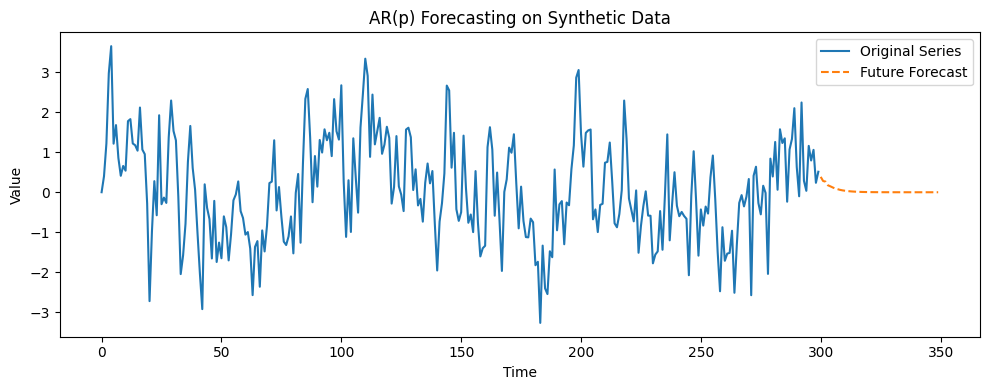

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(x, label="Original Series")
plt.plot(range(n, n + future_steps), future_preds, "--", label="Future Forecast")
plt.title("AR(p) Forecasting on Synthetic Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()

phi_est, intercept_est

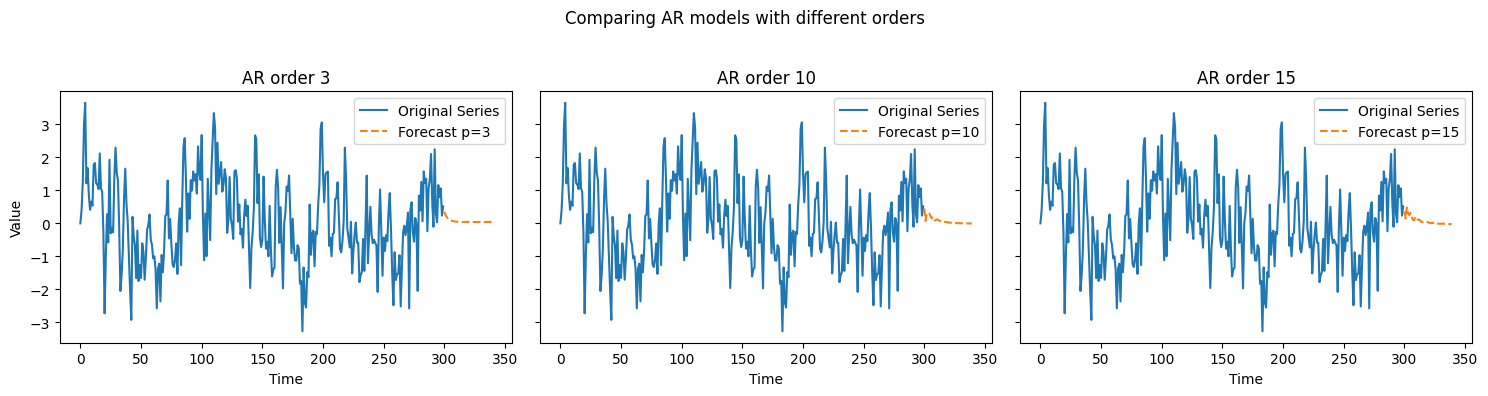

In [13]:
# Compare forecasts from three AR models with different orders
p_small, p_large, p_xlarge = 3, 10, 15


def fit_ar(order):
    X_local, y_local = [], []
    for t in range(order, n):
        X_local.append(x[t - order : t])
        y_local.append(x[t])
    return LinearRegression().fit(X_local, y_local)


model_small = fit_ar(p_small)
model_large = fit_ar(p_large)
model_xlarge = fit_ar(p_xlarge)

future_steps_compare = 40
pred_small = recursive_forecast(model_small, history=x[-p_small:], p=p_small, steps=future_steps_compare)
pred_large = recursive_forecast(model_large, history=x[-p_large:], p=p_large, steps=future_steps_compare)
pred_xlarge = recursive_forecast(model_xlarge, history=x[-p_xlarge:], p=p_xlarge, steps=future_steps_compare)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].plot(x, label="Original Series")
axes[0].plot(range(n, n + future_steps_compare), pred_small, "--", label=f"Forecast p={p_small}")
axes[0].set_title(f"AR order {p_small}")
axes[0].legend()

axes[1].plot(x, label="Original Series")
axes[1].plot(range(n, n + future_steps_compare), pred_large, "--", label=f"Forecast p={p_large}")
axes[1].set_title(f"AR order {p_large}")
axes[1].legend()

axes[2].plot(x, label="Original Series")
axes[2].plot(range(n, n + future_steps_compare), pred_xlarge, "--", label=f"Forecast p={p_xlarge}")
axes[2].set_title(f"AR order {p_xlarge}")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Time")
axes[0].set_ylabel("Value")
plt.suptitle("Comparing AR models with different orders")
plt.tight_layout(rect=(0, 0, 1, 0.95))
